In [203]:
from sklearn import linear_model
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [204]:
%matplotlib inline

In [290]:
cereal = pd.read_csv("cereals.csv")

In [291]:
cereal.head()

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups
0,100%_Bran,N,C,70,4,1,130,10,5,6,280,25,3,1,0.33
1,100%_Natural_Bran,Q,C,120,3,5,15,2,8,8,135,0,3,1,1.00
2,All-Bran,K,C,70,4,1,260,9,7,5,320,25,3,1,0.33
3,All-Bran_with_Extra_Fiber,K,C,50,4,0,140,14,8,0,330,25,3,1,0.50
4,Almond_Delight,R,C,110,2,2,200,1,14,8,-1,25,3,1,0.75


In [292]:
cereal.loc[cereal["potass"] == -1, "potass"] = float("NaN")
cereal.loc[cereal["carbo"] == -1, "carbo"] = float("NaN")
cereal.loc[cereal["sugars"] == -1, "sugars"] = float("NaN")

In [293]:
for col in ["calories", "protein", "fat", "sodium", "fiber", "carbo", "sugars", "potass", "vitamins", "weight", "cups"]:
    cereal[col] = cereal[col] / cereal["cups"]

This standardized all the nutritional information to 1 cup, rather than 1 serving.

In [294]:
cereal_clean = cereal.fillna(cereal.mean())

In [295]:
cereal_nums = cereal_clean.drop(["name", "mfr", "type", "shelf", "weight", "cups"], axis=1)

Needed to replace the -1's with NaN, and then fill in the NaNs. Also needed to drop the columns with non-numerical data. Among the numerical data columns, I tried dropping different columns and keeping others (like weight and shelf) but didn't see much difference whether or not weight, shelf, or cups was kept or dropped. It didn't seem to change the scatter plots below. I decided to only use nutritional data below.

In [296]:
cereal_nums.head()

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins
0,212.121212,12.121212,3.030303,393.939394,30.303030,15.151515,18.181818,848.484848,75.757576
1,120.000000,3.000000,5.000000,15.000000,2.000000,8.000000,8.000000,135.000000,0.000000
2,212.121212,12.121212,3.030303,787.878788,27.272727,21.212121,15.151515,969.696970,75.757576
3,100.000000,8.000000,0.000000,280.000000,28.000000,16.000000,0.000000,660.000000,50.000000
4,146.666667,2.666667,2.666667,266.666667,1.333333,18.666667,10.666667,152.826171,33.333333


In [223]:
import itertools

In [224]:
cereal_cols = list(cereal_nums.drop(["carbo", "sugars", "potass"], axis=1).columns)

In [225]:
combos = list(itertools.combinations(cereal_cols, 2))

In [226]:
choices = []

def regression_for(combo):
    combo = list(combo)
    df = cereal_nums.loc[:, combo + ['potass']]
    df.dropna(inplace=True)
    input_data = df[combo]
    potass = df['potass']
    regr = linear_model.LinearRegression()
    regr.fit(input_data, potass)
    return regr, regr.score(input_data, potass)

for combo in combos:
    regr, score = regression_for(combo)
    choices.append((combo, score))
                   
best = sorted(choices, key=lambda x: x[1])[-1]
print(best)

(('fat', 'fiber'), 0.93415089475422264)


In the above cells, I examined the possibility of using linear regression to fill in the 4 missing data points (1 cereal was missing carbo and sugars, and two other cereals were each missing potass). While the potass showed a good relationship to fiber and fat (and fiber and weight before I removed weight), there was no accurate way to predict carbo or sugars. So I used a fillna with the mean to fill in the missing data points (see above). This seemed to be the simplest way to handle the missing data.

In [297]:
cereal_nums.describe()

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,143.473469,3.617794,1.443074,213.261823,3.596988,19.336341,9.341729,152.826171,37.005144
std,60.224368,2.499900,1.645827,137.373986,5.683868,8.033752,5.856711,166.924082,26.718309
min,50.000000,0.751880,0.000000,0.000000,0.000000,8.000000,0.000000,15.000000,0.000000
25%,110.000000,2.000000,0.000000,140.000000,1.000000,15.000000,3.000000,50.000000,25.000000
50%,134.328358,3.000000,1.000000,223.880597,2.000000,17.910448,10.666667,96.590909,33.333333
75%,160.000000,4.477612,2.666667,280.000000,4.000000,21.333333,13.333333,194.029851,37.313433
max,440.000000,12.121212,9.090909,787.878788,30.303030,68.000000,20.895522,969.696970,133.333333


In [228]:
from sklearn.decomposition import PCA

In [229]:
pca = PCA(n_components=2)
pca.fit(cereal_nums)
reduced_cereal = pca.transform(cereal_nums)

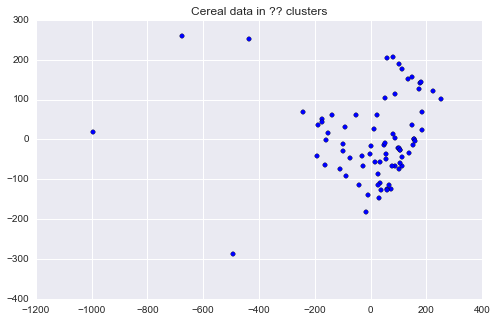

In [380]:
plt.figure(figsize=(8, 5))
plt.scatter(reduced_cereal[:, 0], reduced_cereal[:, 1])
plt.title("Cereal data in ?? clusters")
plt.show()

In [231]:
from sklearn.cluster import KMeans

In [271]:
kmeans = KMeans(4)
cereal_pred = kmeans.fit_predict(reduced_cereal)

In [272]:
cereal_pred

array([3, 0, 3, 3, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 0, 1, 2, 0, 1, 1,
       1, 1, 1, 0, 2, 2, 1, 0, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       2, 1, 1, 2, 1, 2, 2, 1, 0, 0, 2, 0, 2, 2, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 2, 1, 1, 1, 2, 1, 1], dtype=int32)

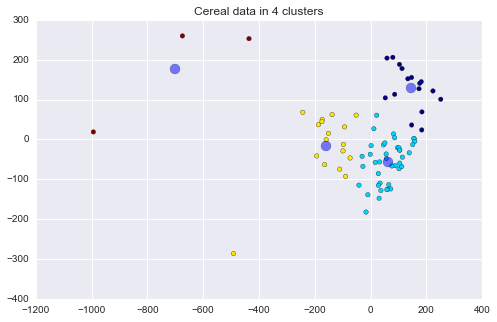

In [381]:
plt.figure(figsize=(8, 5))
plt.scatter(reduced_cereal[:, 0], reduced_cereal[:, 1], c=cereal_pred, cmap="jet")
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], alpha=.5, s=100)
plt.title("Cereal data in 4 clusters")
plt.show()

In the above graph, cluster 0 is the dark blue dots in the upper right, cluster 1 is the light blue, cluster 2 is the yellow (including one outlier near the bottom center), and cluster 3 is the three brown outliers.

In [298]:
cereal_w_pred = cereal

In [299]:
cereal_w_pred["cluster"] = cereal_pred

In [300]:
cereal_w_pred[cereal_w_pred["cluster"] == 0].describe()

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,cluster
count,16.000000,16.000000,16.000000,16.000000,16.000000,15.000000,15.000000,15.000000,16.000000,16.000000,16.000000,16,16
mean,114.575842,3.194207,0.832400,27.466856,2.347559,17.213930,6.453030,111.068446,15.187027,2.000000,1.126707,1,0
std,35.844337,1.609996,1.518820,39.353262,1.818335,7.035441,6.811157,67.075674,16.741998,0.816497,0.382275,0,0
min,50.000000,1.000000,0.000000,0.000000,0.000000,8.000000,0.000000,15.000000,0.000000,1.000000,0.500000,1,0
25%,97.500000,2.000000,0.000000,0.000000,1.000000,12.750000,0.000000,51.666667,0.000000,1.000000,1.000000,1,0
50%,116.818182,3.000000,0.000000,0.000000,2.500000,16.000000,5.000000,95.000000,12.500000,2.000000,1.000000,1,0
75%,137.412935,4.000000,1.083333,58.352273,3.812500,19.250000,11.500000,167.089552,25.852273,3.000000,1.373134,1,0
max,180.000000,7.462687,5.000000,95.000000,5.970149,30.000000,20.000000,220.000000,50.000000,3.000000,2.000000,1,0


In [301]:
cereal_w_pred[cereal_w_pred["cluster"] == 1].describe()

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,cluster
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,40.000000,41.000000,41.000000,41.000000,41,41
mean,123.984873,2.458565,1.143430,226.575967,1.154329,17.483519,8.420580,69.748698,37.738785,2.024390,1.139795,1,1
std,27.557988,1.285213,1.021252,61.638007,1.150060,4.362387,4.850685,40.431682,26.898701,0.821213,0.244826,0,0
min,73.333333,0.751880,0.000000,125.000000,0.000000,10.526316,0.800000,25.000000,16.666667,1.000000,0.666667,1,1
25%,110.000000,1.333333,0.000000,180.000000,0.000000,14.000000,3.000000,34.583333,25.000000,1.000000,1.000000,1,1
50%,110.000000,2.000000,1.000000,220.000000,1.000000,17.045455,10.666667,59.850746,28.409091,2.000000,1.000000,1,1
75%,146.666667,3.000000,1.333333,280.000000,2.000000,21.000000,13.000000,94.147727,33.333333,3.000000,1.333333,1,1
max,186.666667,6.000000,4.000000,373.333333,3.409091,28.000000,16.000000,170.000000,133.333333,3.000000,1.773333,1,1


In [302]:
cereal_w_pred[cereal_w_pred["cluster"] == 2].describe()

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,cluster
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17,17
mean,212.154202,5.554075,2.638652,307.662224,6.264932,26.009711,13.799931,266.341554,50.446963,2.705882,2.078879,1,2
std,81.225851,2.297916,2.351532,106.266440,2.409753,12.382927,4.466670,61.827932,21.250627,0.685994,0.630249,0,0
min,134.328358,2.985075,0.000000,190.000000,3.000000,15.000000,4.477612,171.641791,33.333333,1.000000,1.492537,1,2
25%,160.000000,4.477612,1.333333,270.000000,4.477612,19.402985,12.000000,220.000000,37.313433,3.000000,1.773333,1,2
50%,200.000000,4.477612,2.000000,280.000000,5.970149,22.388060,14.000000,280.000000,37.313433,3.000000,1.985075,1,2
75%,220.000000,6.000000,4.000000,328.358209,7.462687,27.000000,16.000000,303.030303,50.000000,3.000000,2.000000,1,2
max,440.000000,12.000000,9.090909,680.000000,12.000000,68.000000,20.895522,388.059701,100.000000,3.000000,4.000000,1,2


In [303]:
cereal_w_pred[cereal_w_pred["cluster"] == 3].describe()

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,cluster
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3,3.000000,3,3
mean,174.747475,10.747475,2.020202,487.272727,28.525253,17.454545,11.111111,826.060606,67.171717,3,2.686869,1,3
std,64.733212,2.379383,1.749546,266.493056,1.581961,3.281694,9.741061,156.061489,14.871143,0,0.594846,0,0
min,100.000000,8.000000,0.000000,280.000000,27.272727,15.151515,0.000000,660.000000,50.000000,3,2.000000,1,3
25%,156.060606,10.060606,1.515152,336.969697,27.636364,15.575758,7.575758,754.242424,62.878788,3,2.515152,1,3
50%,212.121212,12.121212,3.030303,393.939394,28.000000,16.000000,15.151515,848.484848,75.757576,3,3.030303,1,3
75%,212.121212,12.121212,3.030303,590.909091,29.151515,18.606061,16.666667,909.090909,75.757576,3,3.030303,1,3
max,212.121212,12.121212,3.030303,787.878788,30.303030,21.212121,18.181818,969.696970,75.757576,3,3.030303,1,3


In [304]:
cereal["cluster"] = cereal_pred

In [331]:
low_sodium = cereal[cereal["cluster"] == 0]
low_sodium = low_sodium.set_index(["name"])
low_sodium.head()

,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,cluster
name,,,,,,,,,,,,,,,
100%_Natural_Bran,Q,C,120.000000,3.000000,5,15.000000,2.00,8.0,8.000000,135.000000,0.000000,3,1.000000,1,0
Corn_Pops,K,C,110.000000,1.000000,0,90.000000,1.00,13.0,12.000000,20.000000,25.000000,2,1.000000,1,0
Cream_of_Wheat_(Quick),N,H,100.000000,3.000000,0,80.000000,1.00,21.0,0.000000,NaN,0.000000,2,1.000000,1,0
Frosted_Mini-Wheats,K,C,125.000000,3.750000,0,0.000000,3.75,17.5,8.750000,125.000000,31.250000,2,1.250000,1,0
Golden_Crisp,P,C,113.636364,2.272727,0,51.136364,0.00,12.5,17.045455,45.454545,28.409091,1,1.136364,1,0


In [372]:
cereal[cereal["cluster"] == 1].head()

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,cluster
4,Almond_Delight,R,C,146.666667,2.666667,2.666667,266.666667,1.333333,18.666667,10.666667,NaN,33.333333,3,1.333333,1,1
5,Apple_Cinnamon_Cheerios,G,C,146.666667,2.666667,2.666667,240.000000,2.000000,14.000000,13.333333,93.333333,33.333333,1,1.333333,1,1
6,Apple_Jacks,K,C,110.000000,2.000000,0.000000,125.000000,1.000000,11.000000,14.000000,30.000000,25.000000,2,1.000000,1,1
7,Basic_4,G,C,173.333333,4.000000,2.666667,280.000000,2.666667,24.000000,10.666667,133.333333,33.333333,3,1.773333,1,1
10,Cap'n'Crunch,Q,C,160.000000,1.333333,2.666667,293.333333,0.000000,16.000000,16.000000,46.666667,33.333333,2,1.333333,1,1


In [373]:
cereal[cereal["cluster"] == 2].head()

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,cluster
8,Bran_Chex,R,C,134.328358,2.985075,1.492537,298.507463,5.970149,22.388060,8.955224,186.567164,37.313433,1,1.492537,1,2
9,Bran_Flakes,P,C,134.328358,4.477612,0.000000,313.432836,7.462687,19.402985,7.462687,283.582090,37.313433,3,1.492537,1,2
13,Clusters,G,C,220.000000,6.000000,4.000000,280.000000,4.000000,26.000000,14.000000,210.000000,50.000000,3,2.000000,1,2
19,Cracklin'_Oat_Bran,K,C,220.000000,6.000000,6.000000,280.000000,8.000000,20.000000,14.000000,320.000000,50.000000,3,2.000000,1,2
27,"Fruit_&_Fibre_Dates,_Walnuts,_and_Oats",P,C,179.104478,4.477612,2.985075,238.805970,7.462687,17.910448,14.925373,298.507463,37.313433,3,1.865672,1,2


In [327]:
high_fiber = cereal[cereal["cluster"] == 3]
high_fiber = high_fiber.set_index(["name"])
high_fiber

,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,cluster
name,,,,,,,,,,,,,,,
100%_Bran,N,C,212.121212,12.121212,3.030303,393.939394,30.303030,15.151515,18.181818,848.484848,75.757576,3,3.030303,1,3
All-Bran,K,C,212.121212,12.121212,3.030303,787.878788,27.272727,21.212121,15.151515,969.696970,75.757576,3,3.030303,1,3
All-Bran_with_Extra_Fiber,K,C,100.000000,8.000000,0.000000,280.000000,28.000000,16.000000,0.000000,660.000000,50.000000,3,2.000000,1,3


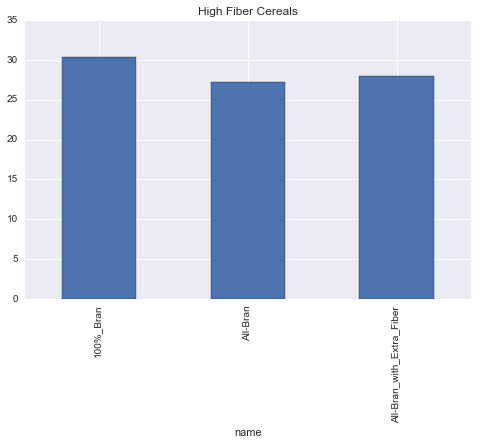

In [330]:
high_fiber.fiber.plot(kind='bar', figsize=(8,5), title="High Fiber Cereals")
plt.hlines()

These cereals from cluster 0 are all very high in fiber - much higher than any of the other cereals in the list. They are the three outliers at the top of the scatter plot. They are also high in potassium compared to the other cereals.

In [337]:
cereal.head()

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,cluster
0,100%_Bran,N,C,212.121212,12.121212,3.030303,393.939394,30.303030,15.151515,18.181818,848.484848,75.757576,3,3.030303,1,3
1,100%_Natural_Bran,Q,C,120.000000,3.000000,5.000000,15.000000,2.000000,8.000000,8.000000,135.000000,0.000000,3,1.000000,1,0
2,All-Bran,K,C,212.121212,12.121212,3.030303,787.878788,27.272727,21.212121,15.151515,969.696970,75.757576,3,3.030303,1,3
3,All-Bran_with_Extra_Fiber,K,C,100.000000,8.000000,0.000000,280.000000,28.000000,16.000000,0.000000,660.000000,50.000000,3,2.000000,1,3
4,Almond_Delight,R,C,146.666667,2.666667,2.666667,266.666667,1.333333,18.666667,10.666667,NaN,33.333333,3,1.333333,1,1


In [367]:
fiber_table = pd.pivot_table(cereal[["fiber", "protein", "fat", "carbo", "sugars", "cluster"]], index="cluster",
                             values=["fiber", "protein", "fat", "carbo", "sugars"])

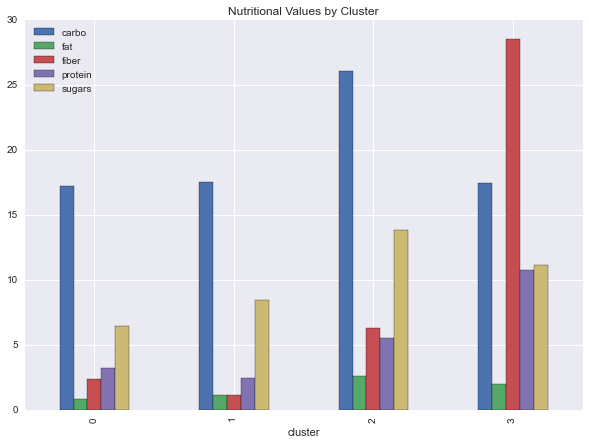

In [378]:
fiber_table.plot(kind="bar", figsize=(10, 7), title="Nutritional Values by Cluster")

The bar graph above shows each of the four clusters and their mean nutritional values in various categories. It's clear that cluster 3 is the high fiber group (see above in the cell with .describe() for the mean, which is 28). These are the three outliers near the top of the scatter plot. Cluster 2 seems to be higher than cluster 0 and 1 in every category, and it is the highest group for carbos and sugars, even higher than cluster 3. It's hard to distinguish cluster 0 and 1 from this graph, so we'll examine a couple of other categories below.

In [364]:
sodium_table = pd.pivot_table(cereal[["sodium", "calories", "potass", "cluster"]], index="cluster",
                              values=["sodium", "calories", "potass"])

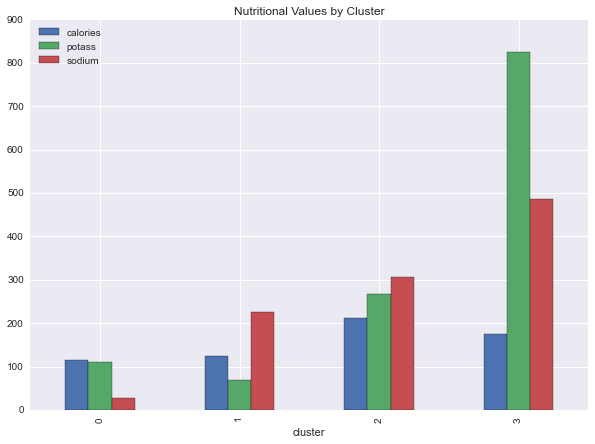

In [379]:
sodium_table.plot(kind="bar", figsize=(10, 7), title="Nutritional Values by Cluster")

Here we see that the high fiber group is also the high potassium group. But it's also the high sodium group. Again we notice that cluster 2 is the highest in calories, which makes sense based on the graph above where it was highest in carbs and sugars. From this graph we can also see that cluster 0 is the low-sodium group as it has far less sodium on average than any of the other groups. So cluster 1 is the group of cereals that tend to be low calorie, but also low in nutritional value, and they also have a higher sodium count than the other low calorie cereals from the low-sodium group (cluster 0).

# Conclusion

Using the k-means clustering algorithm, 4 clusters seems to be a good fit for the data. Less than 4 didn't provide enough distinction between the clusters, and more than 4 seemed to split the groups in an unclear way. The four groups seem to be: cluster 0 - a low-sodium group; cluster 1 - a higher sodium, but low-calorie and low-nutrition group; cluster 2 - a higher calorie, higher carbs, and higher sugar group; cluster 3 - a high fiber, high potassium group. (Scatter plot with clusters reproduced again below.)

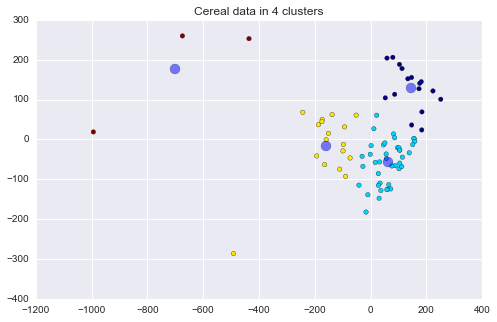

In [382]:
plt.figure(figsize=(8, 5))
plt.scatter(reduced_cereal[:, 0], reduced_cereal[:, 1], c=cereal_pred, cmap="jet")
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], alpha=.5, s=100)
plt.title("Cereal data in 4 clusters")
plt.show()